In [3]:
# -*- coding: utf-8 -*-
import pyprind
#一个进度条和一个百分比指示器对象
import pandas as pd
import os
from nltk.corpus import stopwords
import re
import numpy as np


stop = stopwords.words('english')


def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    #和replace相似 替换
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized


basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
                token = tokenizer(text=txt)
            df = df.append([[labels[l],token ]], ignore_index=True)
            pbar.update()
df.columns = ['sentiment', 'review']
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('movie_data.csv')

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:18


In [6]:
import pyprind
import gensim.models
import re

inpath = 'movie_data.csv'
outpath = 'wordVectTrainResult.bin'
pbar = pyprind.ProgBar(100000)
class csvStream(object):
    def __init__(self,path):
        self.path=path
    def __iter__(self):
        with open(self.path, 'r',) as csv:
            next(csv)  # skip header
            for line in csv:
                text = line[4:-3]
                text = re.sub('[\'\"\[\]\d\b]','',text)   
                while (text[0] == ',') or (text[0] == ' '):
                    text = text[1:]
                pbar.update()
                yield text.split(', ')


lineIterator = csvStream(inpath)
model = gensim.models.Word2Vec()
model.build_vocab(lineIterator)
print('vocabulary building finished, start training...')
model.train(lineIterator,total_examples=model.corpus_count,epochs=1)
model.save(outpath)

0% [###############               ] 100% | ETA: 00:00:11

vocabulary building finished, start training...


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29


D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
0% [#####################] 100% | ETA: 00:00:00
Total time elapsed: 00:25:08


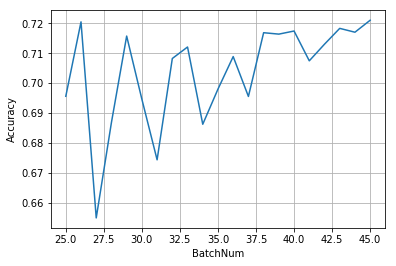

In [5]:
# -*- coding: utf-8 -*-
# load the trained word2vec model
import gensim.models

inpath = 'wordVectTrainResult'
model = gensim.models.Word2Vec.load(inpath)

# start with the IMDB data
import re
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
import pyprind
import numpy as np
import matplotlib.pyplot as plt

stop = stopwords.words('english')
# BatchNum*BatchSize must smaller than 50000
BatchSize = 1000

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized


def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv)  # skip header
        for line in csv:
            text, label = line[4:-3], int(line[-2])
            text = re.sub('[\'\"\[\]\d\b]','',text)
            while text[0] == ',':
                    text = text[1:]
            yield text.split(', '), label


def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y


clf = SGDClassifier(loss='log', random_state=1, n_iter=1)
ACC = []

classes = np.array([0, 1])
pbar = pyprind.ProgBar(21)

for BatchNum in range(25,46): 
    doc_stream = stream_docs(path='movie_data.csv') 
    for _ in range(BatchNum):
        X_train = []
        X_raw, y_train = get_minibatch(doc_stream, size=BatchSize)
        if not X_raw:
            break
        for line in X_raw:
            wordAveVec = np.zeros([100])
            abandon = 0
            try:
                for word in line:
                    wordAveVec = wordAveVec + model[word]
            except KeyError:
                abandon+=1
            wordAveVec = wordAveVec/(len(line) - abandon)
            X_train.append(wordAveVec)    
        clf.partial_fit(X_train, y_train, classes=classes)        

    X_raw_test, y_test = get_minibatch(doc_stream, size=(50000-BatchNum*BatchSize))
    X_test = []
    for line in X_raw_test:
            wordAveVec = np.zeros([100])
            abandon = 0
            try:
                for word in line:
                    wordAveVec = wordAveVec + model[word]
            except KeyError:
                abandon+=1
            wordAveVec = wordAveVec/(len(line) - abandon)
            X_test.append(wordAveVec)
    ACC.append(clf.score(X_test,y_test))
    pbar.update()
x = range(25,46)
plt.plot(x, ACC)
plt.xlabel('BatchNum')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  